<a href="https://colab.research.google.com/github/DanieleBaiocco/IPCV_assignment2/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

In [19]:
!pip install --upgrade calflops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [20]:
from calflops import calculate_flops

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [21]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [22]:
!pip install thop

In [23]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.4 MB/s eta 0:00:00


In [24]:
from pathlib import Path
from PIL import Image
import PIL
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple, Callable, Optional
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import torchmetrics
from torchsummary import summary
import numpy as np
import random
import torchvision
import  matplotlib.pyplot as plt
import os
import copy
import pandas as pd

In [25]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform: Callable[[PIL.Image.Image], Tensor]) -> None:
        super().__init__()
        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]
        tensor_img = self.transform(img).float()
        return tensor_img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []
        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path)
                labels.append(int(label))
        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [26]:
random_state = 42
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PENSO CHE LA COSA MIGLIORE DA FARE SIA INIZIARE CON UN MODELLO MOLTO COMPLICATO CHE OVERFITTI SUL TRAINING DATA. A QUEL PUNTO INSERIRE DELLE REGULARIZATION TECNIQUES CHE MI FACCIANO ARRIVARE A UNA EFFECTIVE CAPACITY OTTIMALE.

In [27]:
!pip install mypy
# Simple mypy cell magic for Colab
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
from mypy import api

@register_cell_magic
def mypy(line, cell):
    for output in api.run(['-c', '\n' + cell] + line.split()):
        if output and not output.startswith('Success'):
            raise TypeError(output)
    get_ipython().run_cell(cell)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 49.8 MB/s eta 0:00:00


In [28]:
num_classes = 43
resize_size = 300
crop_size = 256

In [29]:
def base_transform(resize_size, crop_size):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor()])
def train_transform(crop_size, mean, std):
    return transforms.Compose([transforms.RandomResizedCrop(crop_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])
def val_transform(resize_size, crop_size, mean, std):
    return transforms.Compose([transforms.Resize(resize_size),
                               transforms.CenterCrop(crop_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=mean, std=std)])

In [30]:
#%%mypy --ignore-missing-imports
def create_dataloader(split: str,
                      transform: Callable[[PIL.Image.Image],Tensor],
                      dataset_creation: Callable[[str, Callable[[PIL.Image.Image],Tensor]], Dataset],
                      batch_size: int,
                      shuffle: bool,
                      num_workers: int) -> DataLoader:
      dataset = dataset_creation(split, transform)
      return DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)

In [31]:
def compute_sums(loader):
    sum_red = 0.0
    sum_green = 0.0
    sum_blue = 0.0
    num_pixels = 0

    for images, _ in loader:
        sum_red += images[:, 0, :, :].sum().item()
        sum_green += images[:, 1, :, :].sum().item()
        sum_blue += images[:, 2, :, :].sum().item()
        num_pixels += images[:, 0, :, :].numel()

    return sum_red, sum_green, sum_blue, num_pixels

def compute_means(sum_red, sum_green, sum_blue, num_pixels):
    mean_red = sum_red / num_pixels
    mean_green = sum_green / num_pixels
    mean_blue = sum_blue / num_pixels
    return mean_red, mean_green, mean_blue

def compute_sum_of_squared_diff(loader, mean_red, mean_green, mean_blue):
    sum_red_diff_sq = 0.0
    sum_green_diff_sq = 0.0
    sum_blue_diff_sq = 0.0

    for images, _ in loader:
        sum_red_diff_sq += ((images[:, 0, :, :] - mean_red) ** 2).sum().item()
        sum_green_diff_sq += ((images[:, 1, :, :] - mean_green) ** 2).sum().item()
        sum_blue_diff_sq += ((images[:, 2, :, :] - mean_blue) ** 2).sum().item()

    return sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq

def compute_std(sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq, num_pixels):
    std_red = (sum_red_diff_sq / num_pixels) ** 0.5
    std_green = (sum_green_diff_sq / num_pixels) ** 0.5
    std_blue = (sum_blue_diff_sq / num_pixels) ** 0.5
    return std_red, std_green, std_blue

In [32]:
def get_mean_and_std(loader):
    sum_red, sum_green, sum_blue, num_pixels = compute_sums(loader)
    mean_red, mean_green, mean_blue = compute_means(sum_red, sum_green, sum_blue, num_pixels)
    sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq = compute_sum_of_squared_diff(loader, mean_red, mean_green, mean_blue)
    std_red, std_green, std_blue = compute_std(sum_red_diff_sq, sum_green_diff_sq, sum_blue_diff_sq, num_pixels)
    return [mean_red, mean_green, mean_blue], [std_red, std_green, std_blue]

In [33]:
food_dict = {
    0: "Apple",
    1: "Avocado",
    2: "Banana",
    3: "Kiwi",
    4: "Lemon",
    5: "Lime",
    6: "Mango",
    7: "Melon",
    8: "Nectarine",
    9: "Orange",
    10: "Papaya",
    11: "Passion-Fruit",
    12: "Peach",
    13: "Pear",
    14: "Pineapple",
    15: "Plum",
    16: "Pomegranate",
    17: "Red-Grapefruit",
    18: "Satsumas",
    19: "Juice",
    20: "Milk",
    21: "Oatghurt",
    22: "Oat-Milk",
    23: "Sour-Cream",
    24: "Sour-Milk",
    25: "Soyghurt",
    26: "Soy-Milk",
    27: "Yoghurt",
    28: "Asparagus",
    29: "Aubergine",
    30: "Cabbage",
    31: "Carrots",
    32: "Cucumber",
    33: "Garlic",
    34: "Ginger",
    35: "Leek",
    36: "Mushroom",
    37: "Onion",
    38: "Pepper",
    39: "Potato",
    40: "Red-Beet",
    41: "Tomato",
    42: "Zucchini"
}

In [34]:
base_trainloader =  create_dataloader('train', base_transform(resize_size, crop_size), GroceryStoreDataset, batch_size = 64, shuffle = False, num_workers = 2)
mean, std = get_mean_and_std(base_trainloader)

In [35]:
class SqueezeDims(torch.nn.Module):
    def forward(self, x):
        return x.squeeze()

class GroceryStoreModel(torch.nn.Module):
    def __init__(self, act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 stem_layer: Callable[[int, Callable, Callable, int], torch.nn.Sequential],
                 stage_layer: Callable[[int, Callable, Callable, int], torch.nn.Sequential],
                 dropout_head: float,
                 dropout_fe: float,
                 stem_out_channels: int,
                 num_stages: int,
                 num_classes: int):
        super(GroceryStoreModel, self).__init__()
        self.stem = torch.nn.Sequential(
            stem_layer(stem_out_channels, act_layer, norm_layer, dropout_fe),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stages = torch.nn.ModuleList()
        in_channels = stem_out_channels
        for _ in range(num_stages):
            stage = stage_layer(in_channels, act_layer, norm_layer, dropout_fe)
            self.stages.append(stage)
            in_channels *= 2
        self.head = torch.nn.Sequential(
          torch.nn.AdaptiveAvgPool2d((1, 1)),
          SqueezeDims(),
          torch.nn.Dropout(dropout_head),
          torch.nn.Linear(in_channels, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)
        x = self.head(x)
        return x

In [36]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 padding: int,
                 act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 dropout_rate: float):
        super(ConvBlock,self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.norm_layer = norm_layer(out_channels)
        self.act_layer = act_layer()
        self.dropout_rate = dropout_rate

    def forward(self,x):
        x = self.conv2d(x)
        x = self.norm_layer(x)
        x = self.act_layer(x)
        if self.dropout_rate>0:
          x = torch.nn.Dropout(self.dropout_rate)(x)
        return x

In [37]:
class InceptionBlock(torch.nn.Module):
    def __init__(self, in_channels: int,
                 out_channels: int,
                 act_layer: Callable[[], torch.nn.Module],
                 norm_layer: Callable[[int], torch.nn.Module],
                 dropout_rate: float):
        super(InceptionBlock,self).__init__()
        out_1x1 = out_channels // 4
        red_3x3 = out_1x1 // 2
        out_3x3 = out_1x1
        red_5x5 = out_1x1 // 2
        out_5x5 = out_1x1
        out_1x1_pooling = out_1x1
        # branch1 : k=1,s=1,p=0
        self.branch1 = ConvBlock(in_channels = in_channels,out_channels = out_1x1, kernel_size = 1, stride = 1, padding = 0, act_layer = act_layer, norm_layer = norm_layer, dropout_rate = dropout_rate)
        # branch2 : k=1,s=1,p=0 -> k=3,s=1,p=1
        self.branch2 = torch.nn.Sequential(ConvBlock(in_channels=in_channels, out_channels=red_3x3, kernel_size=1, stride=1,padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate),
                                           ConvBlock(in_channels=red_3x3, out_channels=out_3x3, kernel_size=3, stride=1, padding=1, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))
        # branch3 : k=1,s=1,p=0 -> k=5,s=1,p=2
        self.branch3 = torch.nn.Sequential(ConvBlock(in_channels=in_channels, out_channels=red_5x5,kernel_size=1, stride=1, padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate),
                                           ConvBlock(in_channels=red_5x5, out_channels=out_5x5,kernel_size=5, stride=1, padding=2, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))
        # branch4 : pool(k=3,s=1,p=1) -> k=1,s=1,p=0
        self.branch4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                                           ConvBlock(in_channels=in_channels, out_channels=out_1x1_pooling, kernel_size=1, stride=1, padding=0, act_layer=act_layer, norm_layer=norm_layer, dropout_rate=dropout_rate))

    def forward(self,x):
        # concatenation from dim=1 as dim=0 represents batchsize
        return torch.cat([self.branch1(x),self.branch2(x),self.branch3(x),self.branch4(x)],dim=1)

In [38]:
def inception_stage(in_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    out_channels = in_channels * 2
    return torch.nn.Sequential(
        InceptionBlock(in_channels, out_channels, act_layer, norm_layer, dropout_rate),
        InceptionBlock(out_channels, out_channels, act_layer, norm_layer, dropout_rate),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )
def stem_layer_1(out_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    return torch.nn.Sequential(
        ConvBlock(3, out_channels, kernel_size = 3, stride = 2, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate),
        ConvBlock(out_channels, out_channels, kernel_size = 3, stride= 1, padding = 1,  act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate),
        ConvBlock(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate)
    )
def stem_layer_2(out_channels: int, act_layer: Callable[[], torch.nn.Module], norm_layer: Callable[[int], torch.nn.Module], dropout_rate:float) -> torch.nn.Sequential:
    return ConvBlock(3, out_channels, kernel_size = 7, stride = 2, padding = 1, act_layer = act_layer, norm_layer= norm_layer, dropout_rate = dropout_rate)

NEL SUCCESSIVO MODELLO MI PORTERO' DIETRO LA WEIGHT DECAY, IL LEARNING RATE (ANCHE SE CREDO CAMBIERA')

In [39]:
def create_directory(directory_path):
    try:
        os.makedirs(directory_path, exist_ok=True)
        print(f"Directory '{directory_path}' created successfully")
    except Exception as e:
        print(f"An error occurred while creating the directory '{directory_path}': {e}")

In [40]:
def perform_epoch(model, criterion, dataloader, epoch, num_epochs, metric, device, is_train = False, optimizer=None, scheduler= None):
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        metric.update(preds, targets.to(device))
    epoch_loss = running_loss / len(dataloader)
    metric_value = metric.compute().item()
    return epoch_loss, metric_value

In [41]:
def train(model, num_epochs, criterion, opt, train_dl, val_dl, num_classes, earlystop_patience, scheduler, device):
    train_acc_fn, val_acc_fn = initialize_metrics(num_classes, device)
    best_val_acc = 0.0
    epochs_without_improvement = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_dl, criterion, opt, scheduler, train_acc_fn, device, epoch, num_epochs)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = validate_one_epoch(model, val_dl, criterion, val_acc_fn, device, epoch, num_epochs)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print_epoch_summary(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc)

        best_val_acc, epochs_without_improvement = check_early_stopping(model, val_acc, best_val_acc, epochs_without_improvement, earlystop_patience)
        if epochs_without_improvement >= earlystop_patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }
    return history, best_val_acc

def initialize_metrics(num_classes, device):
    train_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    val_acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes).to(device)
    return train_acc_fn, val_acc_fn

def train_one_epoch(model, train_dl, criterion, opt, scheduler, train_acc_fn, device, epoch, num_epochs):
    model.train()
    train_acc_fn.reset()
    running_loss = 0.0
    for inputs, targets in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
        opt.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward()
        opt.step()
        scheduler.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_acc_fn.update(preds, targets.to(device))
    train_loss = running_loss / len(train_dl)
    train_acc = train_acc_fn.compute().item()
    return train_loss, train_acc

def validate_one_epoch(model, val_dl, criterion, val_acc_fn, device, epoch, num_epochs):
    model.eval()
    val_acc_fn.reset()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(val_dl, desc=f"Epoch {epoch+1}/{num_epochs}"):
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_acc_fn.update(preds, targets.to(device))
    val_loss = running_loss / len(val_dl)
    val_acc = val_acc_fn.compute().item()
    return val_loss, val_acc

def check_early_stopping(model, val_acc, best_val_acc, epochs_without_improvement, earlystop_patience):
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    return best_val_acc, epochs_without_improvement

def save_model_weights(model, best_val_acc, weights_path):
    torch.save(model.state_dict(), f"{weights_path}/model{best_val_acc:.3f}.pt")
    print(f"Saved best model weights with validation accuracy: {best_val_acc:.4f}")

def print_epoch_summary(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")

In [42]:
def create_grocerystoremodel(cnf_model):
    model = GroceryStoreModel(
      act_layer = cnf_model['activation'],
      norm_layer = cnf_model['normalization'],
      stem_layer = cnf_model['stem_layer'],
      stage_layer = inception_stage,
      dropout_head = cnf_model['dropout_head'],
      dropout_fe = cnf_model['dropout_fe'],
      stem_out_channels=64,
      num_stages=cnf_model['num_stages'],
      num_classes=num_classes
    )
    model.to(device)
    return model

In [43]:
def execute(cnf_training, model, device, lr_groups_fn):
    train_dataloader = create_dataloader('train', cnf_training['train_transform'], GroceryStoreDataset, cnf_training['batch_size'], True, 2)
    val_dataloader = create_dataloader('val', cnf_training['test_transform'], GroceryStoreDataset, cnf_training['batch_size'], False, 2)
    test_dataloader = create_dataloader('test', cnf_training['test_transform'], GroceryStoreDataset, cnf_training['batch_size'], False, 2)
    input_shape = (cnf_training['batch_size'], 3, crop_size, crop_size)
    flops, mac, params = calculate_flops(model, input_shape=input_shape,output_as_string=True,
                                      output_precision=4)
    criterion = torch.nn.CrossEntropyLoss()
    # mi serve una funzione che dato un lr e un modello mi ritorna un dizionario di subgroups.
    # nel caso corrente semplicemente fa [{'params': model.parameters(), 'lr': lr}], nel secondo caso fa [{'params': group1, 'lr': lr / 10}, {'params': group2, 'lr': lr}]
    #  Mi deve anche ritornare un array di lrs. Nel primo caso solo [lr], nel secondo caso [lr/10, lr].
    # il primo valore di ritorno e' passato a Adam, il secondo e' passato a OneCycleLR.
    groups_dict, lrs = lr_groups_fn(model, cnf_training['lr'])
    optimizer = optim.Adam(groups_dict, weight_decay=cnf_training['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lrs, steps_per_epoch=len(train_dataloader), epochs=cnf_training['n_epochs'])
    history, best_val_acc = train(model,
          num_epochs = cnf_training['n_epochs'],
          criterion = criterion,
          opt = optimizer,
          train_dl = train_dataloader,
          val_dl = val_dataloader,
          num_classes = 43,
          earlystop_patience = cnf_training['patience'],
          scheduler = scheduler,
          device=device)
    return history, best_val_acc, flops, mac, params

In [44]:
def update_config(cnf, key, new_value):
    cnf_to_return = copy.deepcopy(cnf)
    if key in cnf_to_return:
        cnf_to_return[key] = new_value
    else:
        print(f"Key '{key}' not found in the configuration.")
    return cnf_to_return

In [45]:
def plot_metric(histories, model_names, best_accuracies, metric_type, ylabel, colors, subplot_idx):
    plt.subplot(2, 1, subplot_idx)
    for idx, (history, name, best_acc) in enumerate(zip(histories, model_names, best_accuracies)):
        epochs = range(1, len(history['train_losses']) + 1)
        color = colors(idx)
        plt.plot(epochs, history[f'train_{metric_type}'], label=f'{name} train {ylabel.lower()}', color=color, linestyle='-')
        plt.plot(epochs, history[f'val_{metric_type}'], label=f'{name} val {ylabel.lower()}', color=color, linestyle='--')
        if subplot_idx == 2:
          annotate_best_accuracy(history['val_accuracies'], best_acc)
    plt.title(f'Training and Validation {metric_type.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()


In [46]:
def plot_model_histories(histories, model_names, best_accuracies):
    if len(histories) != len(model_names):
        raise ValueError("The number of histories and model names must be the same.")
    plt.figure(figsize=(20, 15))
    colors = plt.cm.get_cmap('tab10', len(histories))
    plot_metric(histories, model_names, best_accuracies, 'losses', 'Loss', colors, 1)
    plot_metric(histories, model_names, best_accuracies, 'accuracies', 'Accuracy', colors, 2)
    plt.tight_layout()
    plt.show()

In [47]:
def annotate_best_accuracy(val_accuracies, best_acc):
    best_epoch = val_accuracies.index(best_acc) + 1
    plt.text(best_epoch + 0.05 , best_acc, f'Peak: {best_acc:.3f}', color='g', fontsize=10, va='center', ha='left')
    plt.scatter(best_epoch, best_acc, color='g', zorder=5)

In [48]:
cnf_tr = { 'train_transform': train_transform(crop_size, mean, std),
        'test_transform': val_transform(resize_size, crop_size, mean, std),
        'batch_size': 64,
        'lr': 0.001,
        'weight_decay': 0.0005,
        'n_epochs': 30,
        'patience': 15
        }

cnf_mod = { 'activation': lambda: torch.nn.LeakyReLU(),
        'normalization': lambda channels: torch.nn.BatchNorm2d(channels),
        'stem_layer': stem_layer_1,
        'dropout_head': 0.3,
        'dropout_fe': 0.1,
        'num_stages': 4,}

In [99]:
def create_no_subgroups(model, lr):
  return [{'params': model.parameters(), 'lr': lr}], [lr]
def get_head_params(model):
  return [param for name, param in model.named_parameters() if 'fc' not in str(name)]
def create_subgroups(model, lr):
  head_lr = lr * 10
  params_1x = get_head_params(model)
  return [{'params': params_1x, 'lr': lr}, {'params': model.fc.parameters(), 'lr': head_lr}], [lr, head_lr]

TROVA UN MODO PER TROVARE NUMERO DI PARAMETRI
FAI PARAGONE CON QUELLI RIPORTATI DAL SUMMARY

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
columns = ['model_name', 'best_val_acc', 'flops', 'macs', 'n_params']

In [66]:
cnf_mod_1 = update_config(cnf_mod, 'num_stages', 3)
cnf_mod_2 = update_config(cnf_mod, 'dropout_head', 0.0)
cnf_mod_3 = update_config(cnf_mod, 'dropout_fe', 0.0)
cnf_mod_4 = update_config(cnf_mod, 'stem_layer',stem_layer_2)
cnf_mod_5 = update_config(cnf_mod, 'normalization', lambda channels: torch.nn.Identity(channels))
cnf_tr_1 = update_config(cnf_tr, 'train_transform',  val_transform(resize_size, crop_size, mean, std))
cnfs = {'base': (cnf_tr, cnf_mod),
        '3stages': (cnf_tr, cnf_mod_1),
        'no_drphead': (cnf_tr, cnf_mod_2),
        'no_drpfe': (cnf_tr, cnf_mod_3),
        '7x7stem': (cnf_tr, cnf_mod_4),
        'no_bm': (cnf_tr, cnf_mod_5),
        'no_da': (cnf_tr_1, cnf_mod)
        }
abl_study_res = []
abl_study_histories = []
for idx, (conf_name, configuration) in enumerate(cnfs.items()):
    print(f'Training and evaluating {conf_name} model')
    cnf_training, cnf_model = configuration
    model = create_grocerystoremodel(cnf_model)
    history, acc_value, flops, macs, params = execute(cnf_training, model, device, create_no_subgroups)
    abl_study_res.append([conf_name, acc_value, flops, macs, params])
    abl_study_histories.append(history)
abl_study_res = pd.DataFrame(abl_study_res, columns = columns)

abl_study_res.to_csv('abl_results.csv', index=False)
pd.DataFrame(abl_study_histories).to_csv('abl_histories.csv', index = False)

Training and evaluating base model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  4.66 M  
fwd MACs:                                                               134.959 GMACs
fwd FLOPs:                                                              271.577 GFLOPS
fwd+bwd MACs:                                                           404.876 GMACs
fwd+bwd FLOPs:                                                          814.732 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results -----

Epoch 1/30: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 1/30
Train Loss: 3.1304 Train Accuracy: 0.1811
Val Loss: 3.0756 Val Accuracy: 0.1284


Epoch 2/30: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 2/30
Train Loss: 2.2941 Train Accuracy: 0.3462
Val Loss: 2.2722 Val Accuracy: 0.3277


Epoch 3/30: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch 3/30
Train Loss: 1.8406 Train Accuracy: 0.4458
Val Loss: 2.9324 Val Accuracy: 0.2162


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 4/30
Train Loss: 1.5500 Train Accuracy: 0.5091
Val Loss: 2.0273 Val Accuracy: 0.3784


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 5/30
Train Loss: 1.3917 Train Accuracy: 0.5583
Val Loss: 2.2833 Val Accuracy: 0.3818


Epoch 6/30: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Epoch 6/30
Train Loss: 1.3746 Train Accuracy: 0.5610
Val Loss: 2.8498 Val Accuracy: 0.2838


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Epoch 7/30
Train Loss: 1.2406 Train Accuracy: 0.6027
Val Loss: 2.3817 Val Accuracy: 0.4020


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 8/30
Train Loss: 1.1585 Train Accuracy: 0.6405
Val Loss: 2.4787 Val Accuracy: 0.4257


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 9/30
Train Loss: 1.0849 Train Accuracy: 0.6561
Val Loss: 1.9244 Val Accuracy: 0.4662


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Epoch 10/30
Train Loss: 1.0098 Train Accuracy: 0.6712
Val Loss: 1.9679 Val Accuracy: 0.4426


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 11/30
Train Loss: 0.9213 Train Accuracy: 0.7121
Val Loss: 1.4550 Val Accuracy: 0.5541


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 12/30
Train Loss: 0.7521 Train Accuracy: 0.7591
Val Loss: 1.8097 Val Accuracy: 0.4527


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch 13/30
Train Loss: 0.7719 Train Accuracy: 0.7568
Val Loss: 1.9285 Val Accuracy: 0.4155


Epoch 14/30: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 14/30
Train Loss: 0.7608 Train Accuracy: 0.7455
Val Loss: 1.6819 Val Accuracy: 0.4932


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 15/30
Train Loss: 0.5563 Train Accuracy: 0.8277
Val Loss: 1.6790 Val Accuracy: 0.5169


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch 16/30
Train Loss: 0.5494 Train Accuracy: 0.8273
Val Loss: 1.7210 Val Accuracy: 0.5236


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Epoch 17/30
Train Loss: 0.5597 Train Accuracy: 0.8227
Val Loss: 1.4035 Val Accuracy: 0.5541


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 18/30
Train Loss: 0.5197 Train Accuracy: 0.8402
Val Loss: 1.5164 Val Accuracy: 0.5203


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 19/30
Train Loss: 0.4607 Train Accuracy: 0.8568
Val Loss: 1.3610 Val Accuracy: 0.5946


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Epoch 20/30
Train Loss: 0.4179 Train Accuracy: 0.8750
Val Loss: 1.5661 Val Accuracy: 0.6014


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch 21/30
Train Loss: 0.3666 Train Accuracy: 0.8932
Val Loss: 1.4385 Val Accuracy: 0.6014


Epoch 22/30: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 22/30
Train Loss: 0.3293 Train Accuracy: 0.9011
Val Loss: 1.4385 Val Accuracy: 0.5980


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch 23/30
Train Loss: 0.2655 Train Accuracy: 0.9189
Val Loss: 1.1827 Val Accuracy: 0.6588


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Epoch 24/30
Train Loss: 0.2425 Train Accuracy: 0.9337
Val Loss: 1.0915 Val Accuracy: 0.7061


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch 25/30
Train Loss: 0.2054 Train Accuracy: 0.9417
Val Loss: 1.2068 Val Accuracy: 0.6554


Epoch 26/30:  12%|█▏        | 5/42 [00:03<00:24,  1.50it/s]


KeyboardInterrupt: 

<ipython-input-52-3d48084d9135>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(histories))


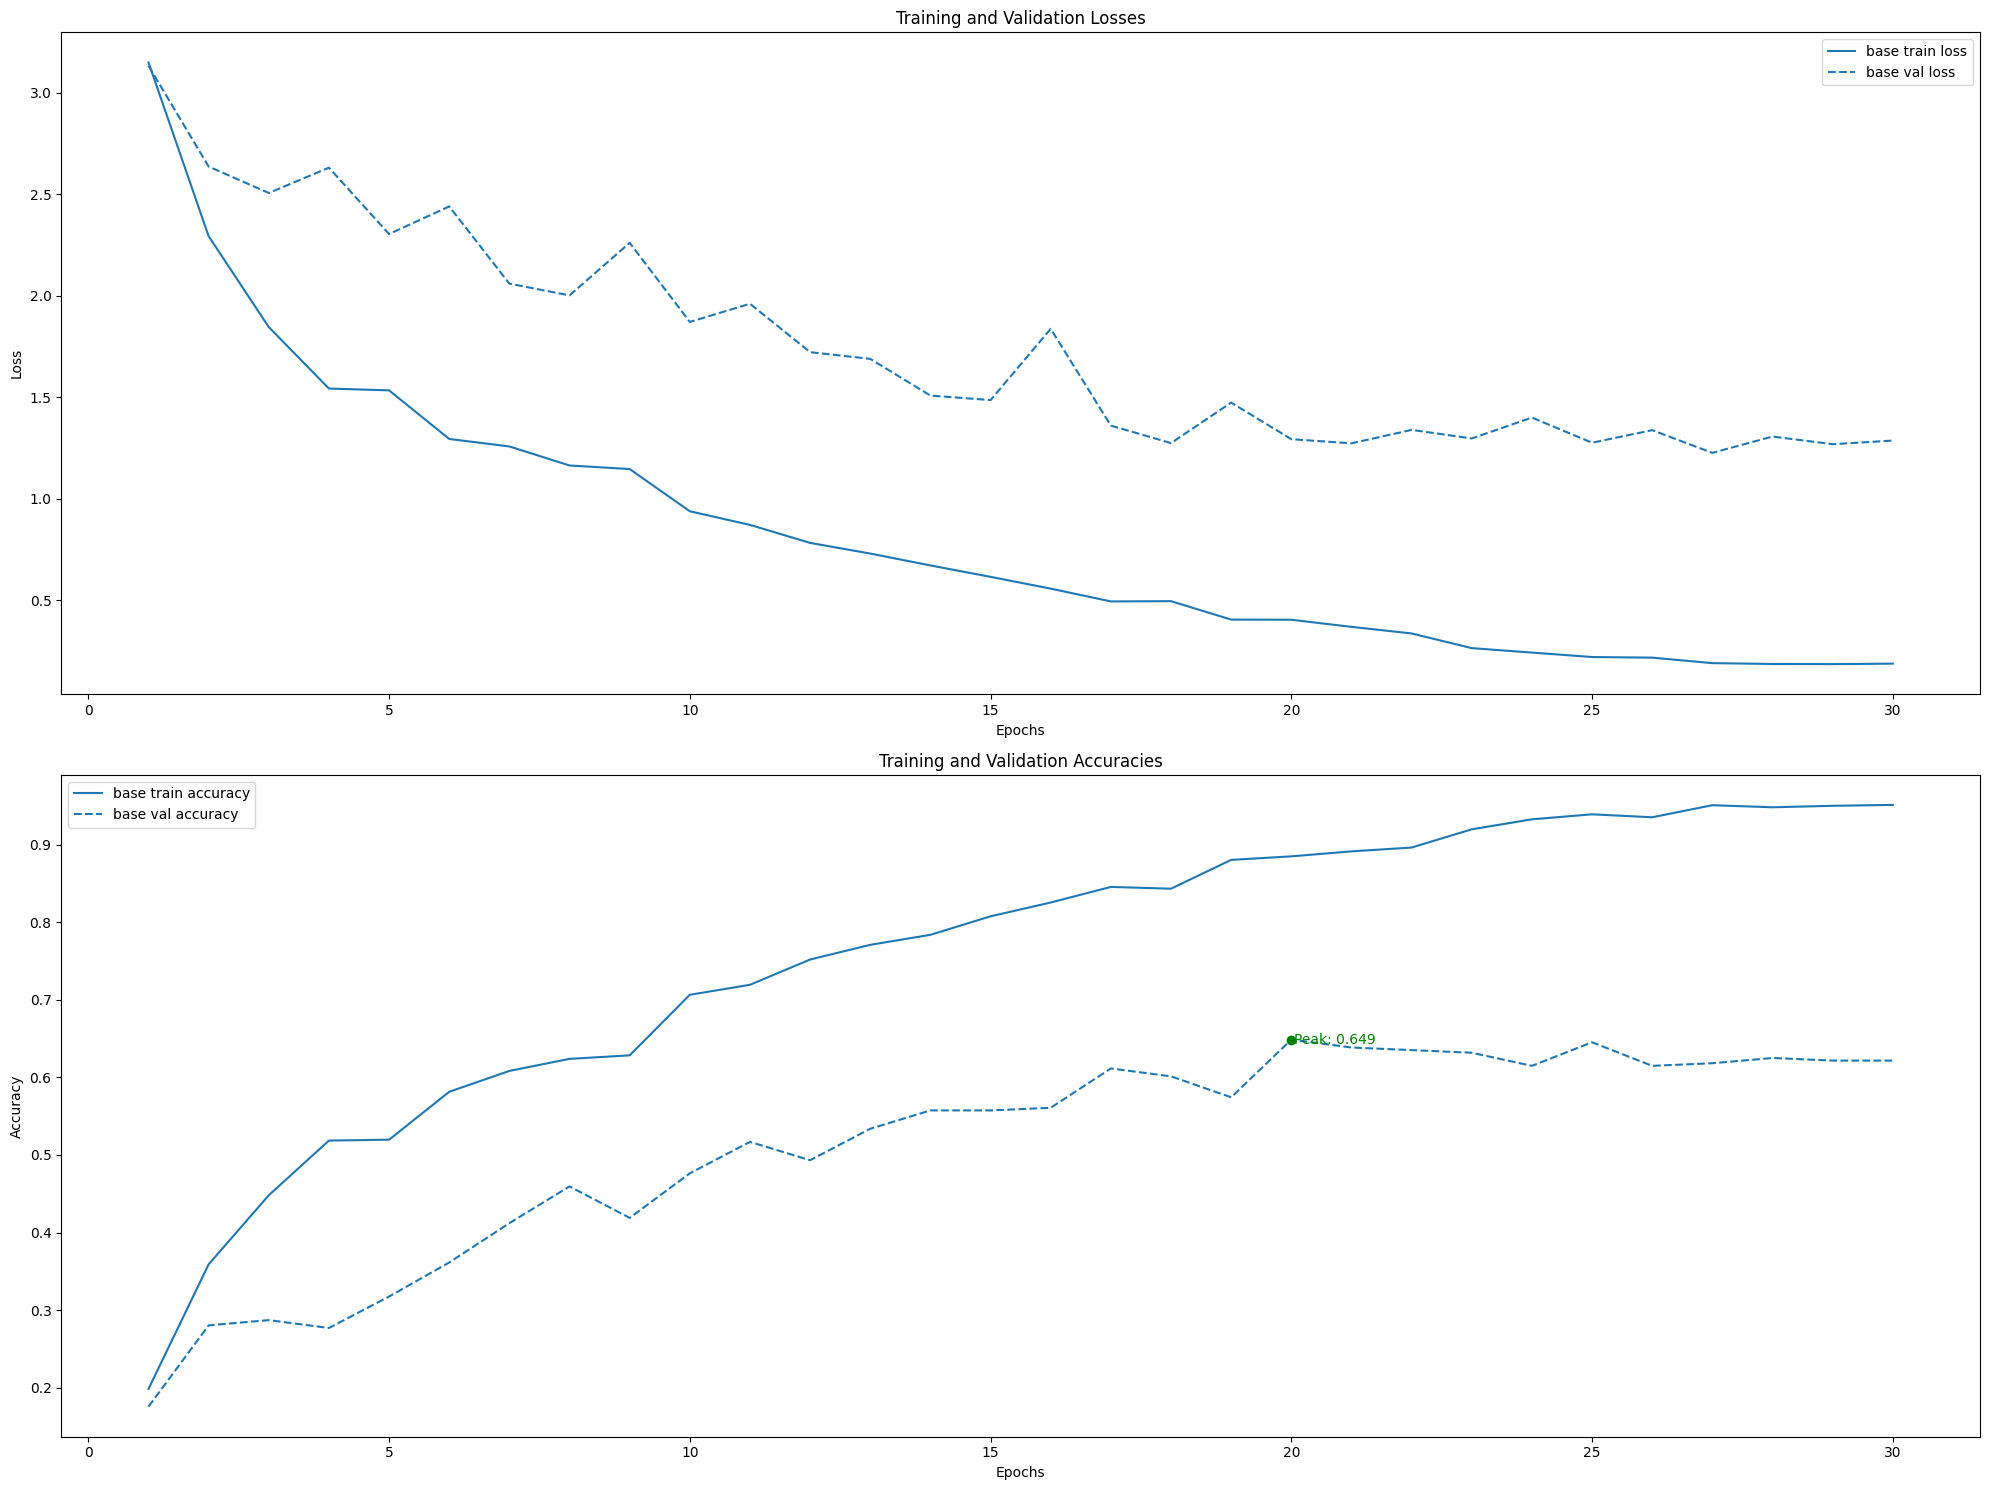

In [57]:
plot_model_histories(abl_study_histories, abl_study_res['model_name'], abl_study_res['best_val_acc'])

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

Posso prima trainarla cosi' a caso, a zero. Semplicemente con i pesi imparati faccio finetuning trainando tutta la rete con gli stessi parametri.

Poi applico le seguenti cose:
1. trainare con fe freezzato per 8 epoche tipo
2. trainare poi per 22 epoche con fe unfreezzato
3. fare training diviso in subgroups per la seconda run usando il metodo *create_subgroups*
4. in entrambi i trainings che vengono performati, utilizzare un lr che sia diviso di un fattore di 10 rispetto a quello usato sopra
5. (optional) rendere piu' grande il feature extractor per fare in modo di ottenere un livello di accuracy piu' alto

1. Aggiunta di un head piu' complicato
https://www.youtube.com/watch?v=qaDe0qQZ5AQ&list=PLHjppeS7qxrUYhY4oQTos0SEtujtRbs99&index=10&ab_channel=AladdinPersson
2. Aggiunta di subgroups in Adam per avere differenti lrs durante il finetuning https://www.youtube.com/watch?v=jTZEG8I8-RI&list=PLHjppeS7qxrUYhY4oQTos0SEtujtRbs99&index=8&ab_channel=RicardoCalix



Fai un metodo che crea una resnet (potendo specificare quanto rendere grande l'head della rete, proprio permettendo di inserire dall'esterno il torch.nn.Module che si vuole) e che fa i seguenti steps all'interno:

In [107]:
def merge_histories(history1, history2):
    merged_history = {
        'train_losses': history1['train_losses'] + history2['train_losses'],
        'train_accuracies': history1['train_accuracies'] + history2['train_accuracies'],
        'val_losses': history1['val_losses'] + history2['val_losses'],
        'val_accuracies': history1['val_accuracies'] + history2['val_accuracies']
    }
    return merged_history

In [108]:
def get_net(head: Callable[[int], torch.nn.Module]):
    resnet = torchvision.models.resnet18(pretrained=True)
    resnet.fc = head(resnet.fc.in_features)
    if isinstance(resnet.fc, torch.nn.Sequential):
        for layer in resnet.fc:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
    elif isinstance(resnet.fc, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

In [109]:
def fine_tune(train_cnf, model, device, lr_groups_fn, fr_epochs = 6):
    train_cnf_f = update_config(train_cnf, 'lr', train_cnf['lr']/10)
    epochs = train_cnf_f['n_epochs']
    unfr_epochs = train_cnf['n_epochs'] - fr_epochs
    train_cnf_fr = update_config(train_cnf_f, 'n_epochs', fr_epochs)

    head_params = get_head_params(model)
    for param in head_params:
       param.requires_grad = False

    resnet_history1, acc_value1, _, _, _ = execute(train_cnf_fr, model, device, create_no_subgroups)

    train_cnf_unfr = update_config(train_cnf_f, 'n_epochs', unfr_epochs)

    for param in head_params:
       param.requires_grad = True
    resnet_history2, acc_value2, flops, macs, params = execute(train_cnf_unfr, model, device, lr_groups_fn)
    return merge_histories(resnet_history1, resnet_history2), max(acc_value1, acc_value2), flops, macs, params


In [110]:
resnets_res = []
resnets_histories = []
resnet_cnfs = {'linear_nofinetune_resnet': (lambda in_feat: torch.nn.Linear(in_feat, num_classes), execute, create_no_subgroups),
               'linear_finetune_resnet': (lambda in_feat: torch.nn.Linear(in_feat, num_classes), fine_tune, create_subgroups),
               'seq_finetune_resnet': (lambda in_feat:  torch.nn.Sequential(
                                        torch.nn.Linear(in_feat, 512),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(512, num_classes)), fine_tune, create_subgroups)}
for idx, (conf_name, configuration) in enumerate(resnet_cnfs.items()):
    print(f'Training and evaluating {conf_name} model')
    head_creator, execute_fn, subgroups_creator = configuration
    model = get_net(head_creator).to(device)
    history, acc_value, flops, macs, params = execute_fn(cnf_tr, model, device, subgroups_creator)
    resnets_res.append([conf_name, acc_value, flops, macs, params])
    resnets_histories.append(history)
resnets_res = pd.DataFrame(resnets_res, columns = columns)
resnets_res.to_csv('resnets_results.csv', index=False)
pd.DataFrame(resnets_histories).to_csv('resnet_histories.csv', index = False)

Training and evaluating linear_nofinetune_resnet model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.2 M  
fwd MACs:                                                               151.6 GMACs
fwd FLOPs:                                                              303.878 GFLOPS
fwd+bwd MACs:                                                           454.801 GMACs
fwd+bwd FLOPs:                                                          911.634 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each modu

Epoch 1/30: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 1/30
Train Loss: 2.7438 Train Accuracy: 0.3511
Val Loss: 1.5870 Val Accuracy: 0.5372


Epoch 2/30: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 2/30
Train Loss: 0.6845 Train Accuracy: 0.8303
Val Loss: 0.6612 Val Accuracy: 0.7804


Epoch 3/30: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 3/30
Train Loss: 0.2787 Train Accuracy: 0.9303
Val Loss: 0.5551 Val Accuracy: 0.7973


Epoch 4/30: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 4/30
Train Loss: 0.2610 Train Accuracy: 0.9322
Val Loss: 0.7562 Val Accuracy: 0.7669


Epoch 5/30: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 5/30
Train Loss: 0.3304 Train Accuracy: 0.9053
Val Loss: 2.2247 Val Accuracy: 0.5676


Epoch 6/30: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 6/30
Train Loss: 0.5681 Train Accuracy: 0.8477
Val Loss: 2.2067 Val Accuracy: 0.5101


Epoch 7/30: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 7/30
Train Loss: 0.5259 Train Accuracy: 0.8523
Val Loss: 2.1624 Val Accuracy: 0.5574


Epoch 8/30: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 8/30
Train Loss: 0.5395 Train Accuracy: 0.8477
Val Loss: 1.8269 Val Accuracy: 0.6081


Epoch 9/30: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 9/30
Train Loss: 0.4675 Train Accuracy: 0.8712
Val Loss: 1.8816 Val Accuracy: 0.5541


Epoch 10/30: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 10/30
Train Loss: 0.2943 Train Accuracy: 0.9133
Val Loss: 1.7668 Val Accuracy: 0.5811


Epoch 11/30: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 11/30
Train Loss: 0.2744 Train Accuracy: 0.9189
Val Loss: 1.5370 Val Accuracy: 0.6520


Epoch 12/30: 100%|██████████| 5/5 [00:01<00:00,  3.74it/s]


Epoch 12/30
Train Loss: 0.2544 Train Accuracy: 0.9299
Val Loss: 1.2349 Val Accuracy: 0.6723


Epoch 13/30: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 13/30
Train Loss: 0.2388 Train Accuracy: 0.9269
Val Loss: 0.7750 Val Accuracy: 0.7770


Epoch 14/30: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch 14/30
Train Loss: 0.2266 Train Accuracy: 0.9394
Val Loss: 1.0552 Val Accuracy: 0.7534


Epoch 15/30: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Epoch 15/30
Train Loss: 0.1865 Train Accuracy: 0.9447
Val Loss: 0.5957 Val Accuracy: 0.8209


Epoch 16/30: 100%|██████████| 5/5 [00:01<00:00,  3.72it/s]


Epoch 16/30
Train Loss: 0.1550 Train Accuracy: 0.9576
Val Loss: 0.9486 Val Accuracy: 0.7264


Epoch 17/30: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 17/30
Train Loss: 0.1632 Train Accuracy: 0.9519
Val Loss: 0.7350 Val Accuracy: 0.7838


Epoch 18/30: 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


Epoch 18/30
Train Loss: 0.1498 Train Accuracy: 0.9568
Val Loss: 0.8956 Val Accuracy: 0.7872


Epoch 19/30: 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]


Epoch 19/30
Train Loss: 0.1117 Train Accuracy: 0.9701
Val Loss: 0.6553 Val Accuracy: 0.8277


Epoch 20/30: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 20/30
Train Loss: 0.1149 Train Accuracy: 0.9659
Val Loss: 0.5791 Val Accuracy: 0.8277


Epoch 21/30: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 21/30
Train Loss: 0.0850 Train Accuracy: 0.9742
Val Loss: 0.5355 Val Accuracy: 0.8615


Epoch 22/30: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


Epoch 22/30
Train Loss: 0.0606 Train Accuracy: 0.9818
Val Loss: 0.5265 Val Accuracy: 0.8378


Epoch 23/30: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch 23/30
Train Loss: 0.0607 Train Accuracy: 0.9803
Val Loss: 0.4885 Val Accuracy: 0.8514


Epoch 24/30: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 24/30
Train Loss: 0.0468 Train Accuracy: 0.9890
Val Loss: 0.4725 Val Accuracy: 0.8547


Epoch 25/30: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 25/30
Train Loss: 0.0419 Train Accuracy: 0.9898
Val Loss: 0.4503 Val Accuracy: 0.8615


Epoch 26/30: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 26/30
Train Loss: 0.0401 Train Accuracy: 0.9886
Val Loss: 0.4627 Val Accuracy: 0.8682


Epoch 27/30: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 27/30
Train Loss: 0.0424 Train Accuracy: 0.9909
Val Loss: 0.4512 Val Accuracy: 0.8716


Epoch 28/30: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 28/30
Train Loss: 0.0442 Train Accuracy: 0.9898
Val Loss: 0.4725 Val Accuracy: 0.8581


Epoch 29/30: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 29/30
Train Loss: 0.0535 Train Accuracy: 0.9886
Val Loss: 0.4575 Val Accuracy: 0.8682


Epoch 30/30: 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]


Epoch 30/30
Train Loss: 0.0438 Train Accuracy: 0.9879
Val Loss: 0.4491 Val Accuracy: 0.8750
Training and evaluating linear_finetune_resnet model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  22.06 K 
fwd MACs:                                                               151.6 GMACs
fwd FLOPs:                                                              303.878 GFLOPS
fwd+bwd MACs:                                                           454.801 GMACs
fwd+bwd FLOPs:                                      

Epoch 1/6: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch 1/6
Train Loss: 4.5557 Train Accuracy: 0.0534
Val Loss: 4.6042 Val Accuracy: 0.0473


Epoch 2/6: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Epoch 2/6
Train Loss: 4.1452 Train Accuracy: 0.0852
Val Loss: 3.9871 Val Accuracy: 0.0574


Epoch 3/6: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch 3/6
Train Loss: 3.6802 Train Accuracy: 0.1129
Val Loss: 3.6780 Val Accuracy: 0.0676


Epoch 4/6: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 4/6
Train Loss: 3.4656 Train Accuracy: 0.1333
Val Loss: 3.5587 Val Accuracy: 0.0777


Epoch 5/6: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 5/6
Train Loss: 3.3510 Train Accuracy: 0.1466
Val Loss: 3.4947 Val Accuracy: 0.0878


Epoch 6/6: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 6/6
Train Loss: 3.3081 Train Accuracy: 0.1466
Val Loss: 3.5091 Val Accuracy: 0.0845

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.2 M  
fwd MACs:                                                               151.6 GMACs
fwd FLOPs:                                                              303.878 GFLOPS
fwd+bwd MACs:                                                           454.801 GMACs
fwd+bwd FLOPs:                                                          911.634 GFLOPS

-------------------

Epoch 1/24: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch 1/24
Train Loss: 2.9960 Train Accuracy: 0.2265
Val Loss: 2.8146 Val Accuracy: 0.2872


Epoch 2/24: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 2/24
Train Loss: 2.1551 Train Accuracy: 0.4417
Val Loss: 1.9320 Val Accuracy: 0.4628


Epoch 3/24: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch 3/24
Train Loss: 1.2421 Train Accuracy: 0.6973
Val Loss: 1.1011 Val Accuracy: 0.6993


Epoch 4/24: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 4/24
Train Loss: 0.5990 Train Accuracy: 0.8731
Val Loss: 0.7368 Val Accuracy: 0.7601


Epoch 5/24: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 5/24
Train Loss: 0.3411 Train Accuracy: 0.9288
Val Loss: 0.5121 Val Accuracy: 0.8446


Epoch 6/24: 100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch 6/24
Train Loss: 0.2260 Train Accuracy: 0.9496
Val Loss: 0.4299 Val Accuracy: 0.8716


Epoch 7/24: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 7/24
Train Loss: 0.1676 Train Accuracy: 0.9629
Val Loss: 0.5042 Val Accuracy: 0.8311


Epoch 8/24: 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


Epoch 8/24
Train Loss: 0.1574 Train Accuracy: 0.9621
Val Loss: 0.3951 Val Accuracy: 0.8885


Epoch 9/24: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 9/24
Train Loss: 0.1197 Train Accuracy: 0.9735
Val Loss: 0.3194 Val Accuracy: 0.8818


Epoch 10/24: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 10/24
Train Loss: 0.1182 Train Accuracy: 0.9678
Val Loss: 0.3685 Val Accuracy: 0.8716


Epoch 11/24: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Epoch 11/24
Train Loss: 0.1072 Train Accuracy: 0.9689
Val Loss: 0.3285 Val Accuracy: 0.8784


Epoch 12/24: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Epoch 12/24
Train Loss: 0.0948 Train Accuracy: 0.9750
Val Loss: 0.3349 Val Accuracy: 0.8818


Epoch 13/24: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


Epoch 13/24
Train Loss: 0.0905 Train Accuracy: 0.9758
Val Loss: 0.3340 Val Accuracy: 0.8953


Epoch 14/24: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]


Epoch 14/24
Train Loss: 0.0721 Train Accuracy: 0.9833
Val Loss: 0.4200 Val Accuracy: 0.8547


Epoch 15/24: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 15/24
Train Loss: 0.0900 Train Accuracy: 0.9784
Val Loss: 0.2902 Val Accuracy: 0.8953


Epoch 16/24: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 16/24
Train Loss: 0.0687 Train Accuracy: 0.9845
Val Loss: 0.3586 Val Accuracy: 0.8716


Epoch 17/24: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Epoch 17/24
Train Loss: 0.0595 Train Accuracy: 0.9856
Val Loss: 0.3257 Val Accuracy: 0.8784


Epoch 18/24: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 18/24
Train Loss: 0.0596 Train Accuracy: 0.9845
Val Loss: 0.3424 Val Accuracy: 0.8885


Epoch 19/24: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 19/24
Train Loss: 0.0520 Train Accuracy: 0.9879
Val Loss: 0.3317 Val Accuracy: 0.8851


Epoch 20/24: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch 20/24
Train Loss: 0.0482 Train Accuracy: 0.9883
Val Loss: 0.3332 Val Accuracy: 0.8885


Epoch 21/24: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch 21/24
Train Loss: 0.0263 Train Accuracy: 0.9947
Val Loss: 0.3285 Val Accuracy: 0.8818


Epoch 22/24: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 22/24
Train Loss: 0.0588 Train Accuracy: 0.9867
Val Loss: 0.3222 Val Accuracy: 0.8953


Epoch 23/24: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


Epoch 23/24
Train Loss: 0.0554 Train Accuracy: 0.9879
Val Loss: 0.3176 Val Accuracy: 0.9122


Epoch 24/24: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 24/24
Train Loss: 0.0493 Train Accuracy: 0.9886
Val Loss: 0.3120 Val Accuracy: 0.9020
Training and evaluating seq_finetune_resnet model

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  284.71 K
fwd MACs:                                                               151.617 GMACs
fwd FLOPs:                                                              303.912 GFLOPS
fwd+bwd MACs:                                                           454.851 GMACs
fwd+bwd FLOPs:                                       

Epoch 1/6: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 1/6
Train Loss: 4.0987 Train Accuracy: 0.0515
Val Loss: 3.6907 Val Accuracy: 0.1351


Epoch 2/6: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Epoch 2/6
Train Loss: 3.1196 Train Accuracy: 0.2170
Val Loss: 2.8474 Val Accuracy: 0.2905


Epoch 3/6: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 3/6
Train Loss: 2.4636 Train Accuracy: 0.3773
Val Loss: 2.3226 Val Accuracy: 0.3953


Epoch 4/6: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Epoch 4/6
Train Loss: 2.0765 Train Accuracy: 0.4742
Val Loss: 2.0873 Val Accuracy: 0.4392


Epoch 5/6: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch 5/6
Train Loss: 1.8702 Train Accuracy: 0.5523
Val Loss: 1.9712 Val Accuracy: 0.4797


Epoch 6/6: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Epoch 6/6
Train Loss: 1.8019 Train Accuracy: 0.5545
Val Loss: 1.9565 Val Accuracy: 0.4831

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.46 M 
fwd MACs:                                                               151.617 GMACs
fwd FLOPs:                                                              303.912 GFLOPS
fwd+bwd MACs:                                                           454.851 GMACs
fwd+bwd FLOPs:                                                          911.735 GFLOPS

-----------------

Epoch 1/24: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 1/24
Train Loss: 1.6664 Train Accuracy: 0.5879
Val Loss: 1.6236 Val Accuracy: 0.5777


Epoch 2/24: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


Epoch 2/24
Train Loss: 1.1555 Train Accuracy: 0.7277
Val Loss: 1.1255 Val Accuracy: 0.6453


Epoch 3/24: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


Epoch 3/24
Train Loss: 0.6232 Train Accuracy: 0.8470
Val Loss: 0.7098 Val Accuracy: 0.7703


Epoch 4/24: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


Epoch 4/24
Train Loss: 0.3170 Train Accuracy: 0.9246
Val Loss: 0.5700 Val Accuracy: 0.8108


Epoch 5/24: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 5/24
Train Loss: 0.2466 Train Accuracy: 0.9337
Val Loss: 0.4211 Val Accuracy: 0.8547


Epoch 6/24: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


Epoch 6/24
Train Loss: 0.2179 Train Accuracy: 0.9428
Val Loss: 0.5561 Val Accuracy: 0.7939


Epoch 7/24: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Epoch 7/24
Train Loss: 0.1860 Train Accuracy: 0.9473
Val Loss: 0.5662 Val Accuracy: 0.8209


Epoch 8/24: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch 8/24
Train Loss: 0.1840 Train Accuracy: 0.9447
Val Loss: 0.7147 Val Accuracy: 0.8108


Epoch 9/24: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 9/24
Train Loss: 0.1222 Train Accuracy: 0.9644
Val Loss: 0.6128 Val Accuracy: 0.8176


Epoch 10/24: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Epoch 10/24
Train Loss: 0.1120 Train Accuracy: 0.9663
Val Loss: 0.5015 Val Accuracy: 0.8378


Epoch 11/24: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 11/24
Train Loss: 0.0902 Train Accuracy: 0.9739
Val Loss: 0.3849 Val Accuracy: 0.8784


Epoch 12/24: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 12/24
Train Loss: 0.1073 Train Accuracy: 0.9663
Val Loss: 0.4205 Val Accuracy: 0.8750


Epoch 13/24: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 13/24
Train Loss: 0.0939 Train Accuracy: 0.9739
Val Loss: 0.3293 Val Accuracy: 0.8885


Epoch 14/24: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


Epoch 14/24
Train Loss: 0.0715 Train Accuracy: 0.9750
Val Loss: 0.5386 Val Accuracy: 0.8615


Epoch 15/24: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Epoch 15/24
Train Loss: 0.0725 Train Accuracy: 0.9811
Val Loss: 0.3913 Val Accuracy: 0.9020


Epoch 16/24: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch 16/24
Train Loss: 0.0744 Train Accuracy: 0.9799
Val Loss: 0.4339 Val Accuracy: 0.8716


Epoch 17/24: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


Epoch 17/24
Train Loss: 0.0686 Train Accuracy: 0.9814
Val Loss: 0.3367 Val Accuracy: 0.8885


Epoch 18/24: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


Epoch 18/24
Train Loss: 0.0508 Train Accuracy: 0.9856
Val Loss: 0.2943 Val Accuracy: 0.9155


Epoch 19/24: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


Epoch 19/24
Train Loss: 0.0530 Train Accuracy: 0.9852
Val Loss: 0.2897 Val Accuracy: 0.9020


Epoch 20/24: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Epoch 20/24
Train Loss: 0.0505 Train Accuracy: 0.9864
Val Loss: 0.2641 Val Accuracy: 0.8986


Epoch 21/24: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


Epoch 21/24
Train Loss: 0.0339 Train Accuracy: 0.9917
Val Loss: 0.2919 Val Accuracy: 0.8953


Epoch 22/24: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


Epoch 22/24
Train Loss: 0.0286 Train Accuracy: 0.9924
Val Loss: 0.2808 Val Accuracy: 0.8953


Epoch 23/24: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Epoch 23/24
Train Loss: 0.0378 Train Accuracy: 0.9890
Val Loss: 0.2771 Val Accuracy: 0.8953


Epoch 24/24: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]

Epoch 24/24
Train Loss: 0.0365 Train Accuracy: 0.9894
Val Loss: 0.2776 Val Accuracy: 0.9020


<ipython-input-46-3d48084d9135>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(histories))


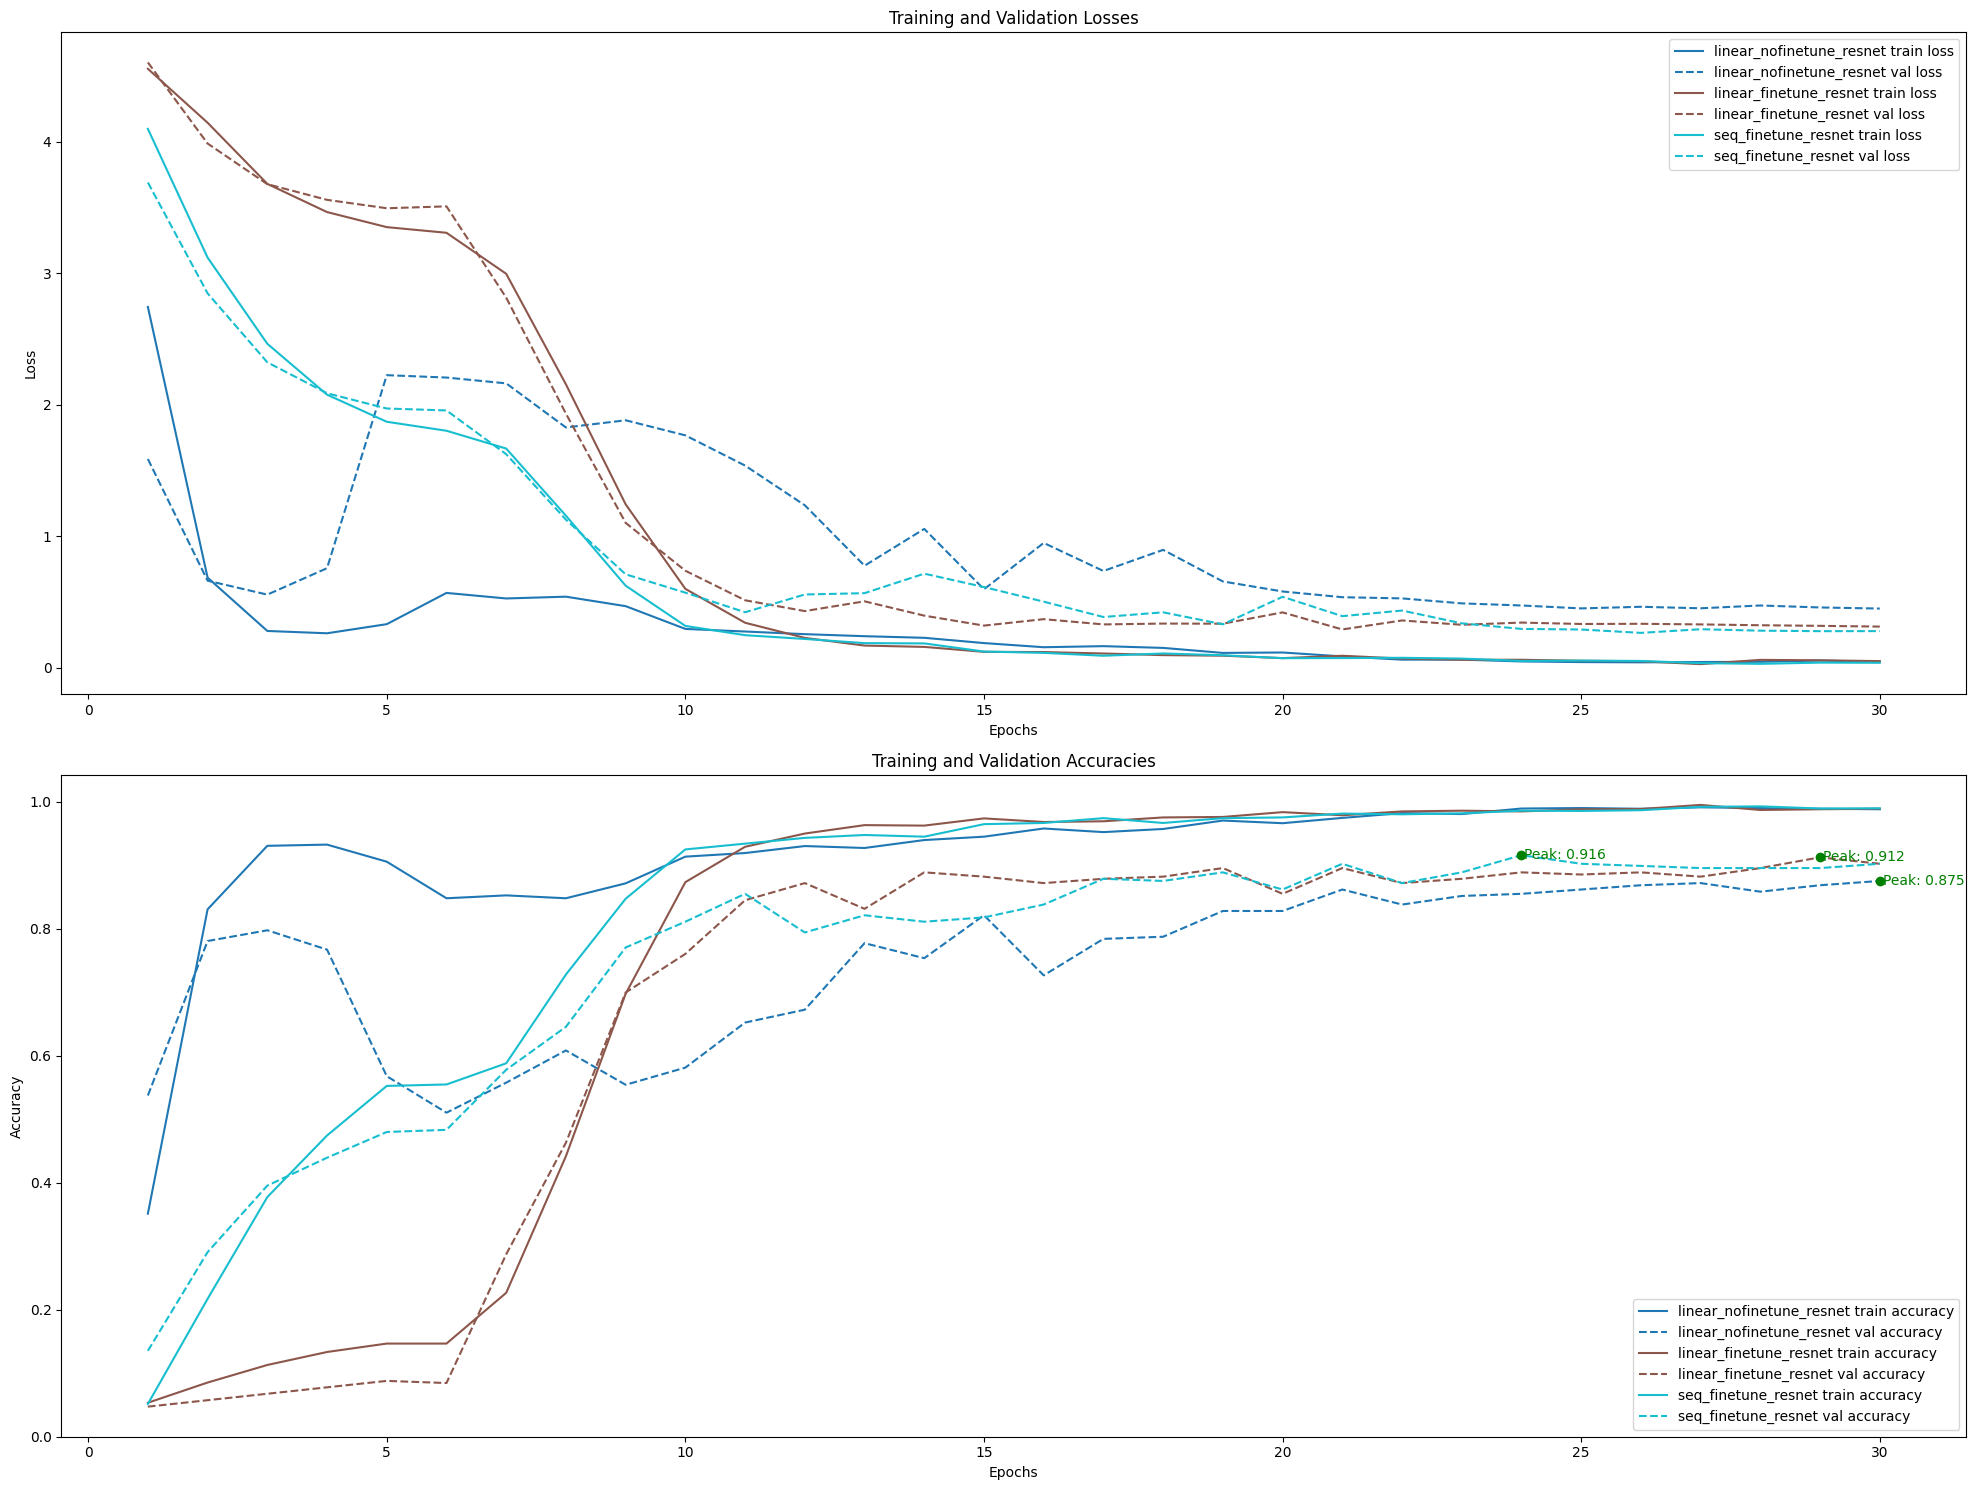

In [111]:
plot_model_histories(resnets_histories, resnets_res['model_name'], resnets_res['best_val_acc'])